In [1]:
import os, math, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
with open(r'D:\py\train.pkl', 'rb') as trn:
    trnData = pickle.load(trn)

In [205]:
with open(r'D:\py\test.pkl', 'rb') as tst:
    tstData = pickle.load(tst)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
trnData.head()

code  date       f_0       f_1       f_2       f_3       f_4  \
4456454  s_4692     0 -0.702830  0.037067  1.942280  0.801096 -0.006199   
4307494  s_2993     0 -0.806224 -0.000083  1.380909  0.772071 -0.016396   
4335761  s_3541     0 -1.505593  0.012782  1.286695  0.823303 -0.145311   
4380664  s_4189     0 -0.253071  0.011285  2.323603  0.884484  0.055950   
4611516  s_1155     0 -1.570486 -0.011454  2.127275  0.747357 -0.124798   

              f_5  f_6       f_7       f_8       f_9      f_10      f_11  \
4456454  0.533025  0.0  0.897703  2.565819  0.943543 -0.041699  1.123725   
4307494  0.469204  0.0  0.926102  2.576960  0.925218 -0.028462  0.840703   
4335761  0.239580  0.0  0.822199  2.927710  0.921083  0.010997  1.140557   
4380664  0.492526  0.0  1.098327  2.595145  0.936513  0.046809  1.268574   
4611516  0.316993  0.0  0.927854  2.710364  0.938786  0.048799  1.041251   

             f_12      f_13      f_14      f_15      f_16          f_17  \
4456454  0.955936 -0.047794  0.026908 -0.002266  0.057543 -5.381960e-05   
4307494  0.883616 -0.034758 -0.002518 -0.044532  0.006992  1.206800e-05   
4335761  0.874939 -0.073057  0.011109  0.005666 -0.024396  2.397720e-05   
4380664  1.087053 -0.073244  0.034283  0.002929  0.021058 -3.387910e-05   
4611516  0.965608 -0.124693  0.004024 -0.057048 -0.010665  8.205000e-07   

             f_18      f_19         y  
4456454  0.080891  0.006540  0.131208  
4307494  0.013970  0.002926  0.127212  
4335761  0.033982 -0.003505  0.003701  
4380664 -0.007128  0.084860 -0.063719  
4611516  0.049440 -0.026340 -0.139798

In [6]:
trnData.shape

(2431658, 23)

In [99]:
df = trnData.copy()

In [100]:
df.head()

code  date       f_0       f_1       f_2       f_3       f_4  \
4456454  s_4692     0 -0.702830  0.037067  1.942280  0.801096 -0.006199   
4307494  s_2993     0 -0.806224 -0.000083  1.380909  0.772071 -0.016396   
4335761  s_3541     0 -1.505593  0.012782  1.286695  0.823303 -0.145311   
4380664  s_4189     0 -0.253071  0.011285  2.323603  0.884484  0.055950   
4611516  s_1155     0 -1.570486 -0.011454  2.127275  0.747357 -0.124798   

              f_5  f_6       f_7       f_8       f_9      f_10      f_11  \
4456454  0.533025  0.0  0.897703  2.565819  0.943543 -0.041699  1.123725   
4307494  0.469204  0.0  0.926102  2.576960  0.925218 -0.028462  0.840703   
4335761  0.239580  0.0  0.822199  2.927710  0.921083  0.010997  1.140557   
4380664  0.492526  0.0  1.098327  2.595145  0.936513  0.046809  1.268574   
4611516  0.316993  0.0  0.927854  2.710364  0.938786  0.048799  1.041251   

             f_12      f_13      f_14      f_15      f_16          f_17  \
4456454  0.955936 -0.047794  0.026908 -0.002266  0.057543 -5.381960e-05   
4307494  0.883616 -0.034758 -0.002518 -0.044532  0.006992  1.206800e-05   
4335761  0.874939 -0.073057  0.011109  0.005666 -0.024396  2.397720e-05   
4380664  1.087053 -0.073244  0.034283  0.002929  0.021058 -3.387910e-05   
4611516  0.965608 -0.124693  0.004024 -0.057048 -0.010665  8.205000e-07   

             f_18      f_19         y  
4456454  0.080891  0.006540  0.131208  
4307494  0.013970  0.002926  0.127212  
4335761  0.033982 -0.003505  0.003701  
4380664 -0.007128  0.084860 -0.063719  
4611516  0.049440 -0.026340 -0.139798

In [10]:
"""def numbers_to_days(start_date_str, numbers):
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    datetimes = []
    # The number 1 corresponds to the start date (0 day offset)
    for num in numbers:
        offset = timedelta(days=num)
        datetimes.append(start_date + offset)
    return datetimes
    """

In [11]:
#number_list = range(0, df['date'].max())


In [12]:
#date_results = numbers_to_days("2024-01-01", number_list)

In [101]:
df['date'] = pd.to_datetime(df['date'], unit='D', origin='2024-01-01')

In [81]:
#df_d['date'].max().where(df_d['code'] == 's_0')
#df_d.where(df_d['code'] == 's_0').max()
#df_d.where(df_d['code'] == 's_0').sort_values(by='date', ascending=False)

In [94]:
#df_d['date'] = pd.to_datetime(df_d['date'])

In [39]:
#df['date'] = numbers_to_days("2024-01-01", df['date'])

In [102]:
df = df.sort_values(["code", "date"]).reset_index(drop=True)

In [103]:
df.head()

code       date       f_0       f_1       f_2  f_3       f_4       f_5  f_6  \
0  s_0 2024-05-01  0.394700 -0.063500  7.562500  0.0  0.048135  0.582772  0.0   
1  s_0 2024-05-02  0.302114 -0.039620  7.562500  0.0  0.003498  0.571028  0.0   
2  s_0 2024-05-03  0.210442 -0.021979  7.562500  0.0 -0.035704  0.566825  0.0   
3  s_0 2024-05-04  0.091796 -0.014817  7.562500  0.0 -0.073599  0.562066  0.0   
4  s_0 2024-05-05 -0.000065 -0.010519  9.651191  0.0 -0.105692  0.548534  0.0   

        f_7  f_8       f_9  f_10  f_11      f_12      f_13      f_14  \
0  1.952015  0.0  0.933833   0.0   0.0  1.452481  0.000000  0.000000   
1  1.718900  0.0  0.921778   0.0   0.0  1.322955  0.000000  0.000000   
2  1.529921  0.0  0.915979   0.0   0.0  1.203602  0.000000  0.000000   
3  1.483651  0.0  0.919647   0.0   0.0  1.197761  0.000000  0.000000   
4  1.482967  0.0  0.921448   0.0   0.0  1.224910 -0.017885 -0.032768   

       f_15      f_16      f_17      f_18  f_19         y  
0  0.000000  0.130791  0.000070 -0.009330   0.0 -0.046793  
1  0.007457  0.132136  0.000037 -0.000959   0.0 -0.001007  
2  0.017134  0.121744  0.000026  0.024070   0.0  0.057230  
3  0.030256  0.115516 -0.000006  0.030045   0.0 -0.018251  
4  0.040731  0.103038 -0.000039  0.023343   0.0 -0.038166

In [44]:
#df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(["code", "date"]).reset_index(drop=True)

In [104]:
# Encode series id
df["code_id"] = df["code"].astype("category").cat.codes.astype(np.int32)

In [105]:
df['t_idx'] = df.groupby('code').cumcount().astype(np.int32)

In [106]:
df.head()

code       date       f_0       f_1       f_2  f_3       f_4       f_5  f_6  \
0  s_0 2024-05-01  0.394700 -0.063500  7.562500  0.0  0.048135  0.582772  0.0   
1  s_0 2024-05-02  0.302114 -0.039620  7.562500  0.0  0.003498  0.571028  0.0   
2  s_0 2024-05-03  0.210442 -0.021979  7.562500  0.0 -0.035704  0.566825  0.0   
3  s_0 2024-05-04  0.091796 -0.014817  7.562500  0.0 -0.073599  0.562066  0.0   
4  s_0 2024-05-05 -0.000065 -0.010519  9.651191  0.0 -0.105692  0.548534  0.0   

        f_7  f_8       f_9  f_10  f_11      f_12      f_13      f_14  \
0  1.952015  0.0  0.933833   0.0   0.0  1.452481  0.000000  0.000000   
1  1.718900  0.0  0.921778   0.0   0.0  1.322955  0.000000  0.000000   
2  1.529921  0.0  0.915979   0.0   0.0  1.203602  0.000000  0.000000   
3  1.483651  0.0  0.919647   0.0   0.0  1.197761  0.000000  0.000000   
4  1.482967  0.0  0.921448   0.0   0.0  1.224910 -0.017885 -0.032768   

       f_15      f_16      f_17      f_18  f_19         y  code_id  t_idx  
0  0.000000  0.130791  0.000070 -0.009330   0.0 -0.046793        0      0  
1  0.007457  0.132136  0.000037 -0.000959   0.0 -0.001007        0      1  
2  0.017134  0.121744  0.000026  0.024070   0.0  0.057230        0      2  
3  0.030256  0.115516 -0.000006  0.030045   0.0 -0.018251        0      3  
4  0.040731  0.103038 -0.000039  0.023343   0.0 -0.038166        0      4

In [18]:
dfs0 = df[df['code']=='s_0']

In [19]:
dfs0.shape

(429, 24)

In [20]:
results0 = seasonal_decompose(dfs0['y'], model='additive', period=30)

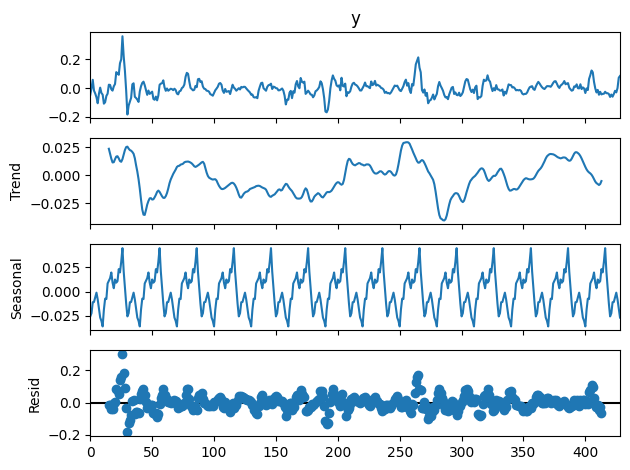

In [21]:
results0.plot()
plt.show()

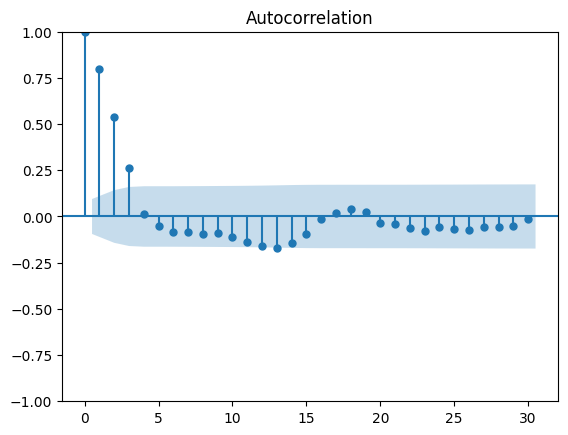

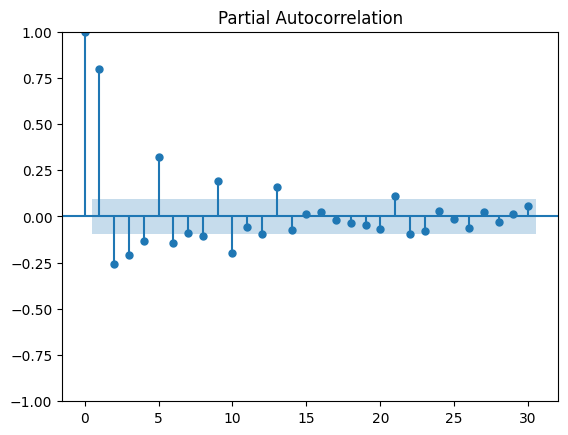

In [43]:
acf_org = plot_acf(dfs0['y'],lags=30)
acf_org = plot_pacf(dfs0['y'],lags=30)

In [23]:
adf_test = adfuller(dfs0['y'])
print(f'p-value : {adf_test[1]}')

p-value : (np.float64(-5.988876689518397), np.float64(1.7651073494359978e-07), 13, 415, {'1%': np.float64(-3.446205926287236), '5%': np.float64(-2.8685297226414734), '10%': np.float64(-2.570493298011322)}, np.float64(-1843.160032652444))


In [ ]:
#stat, p, _, _, _, _ = f.adf_test(full_res=True)

In [86]:
#sns.set(rc={'figure.figsize':(24,8)})
#ax=sns.lineplot(data=df,x='date',y='y',hue='code')
#ax.axes.set_title("\nPlot\n",fontsize=20);

In [25]:
result = seasonal_decompose(df['y'], model='additive', period=12)

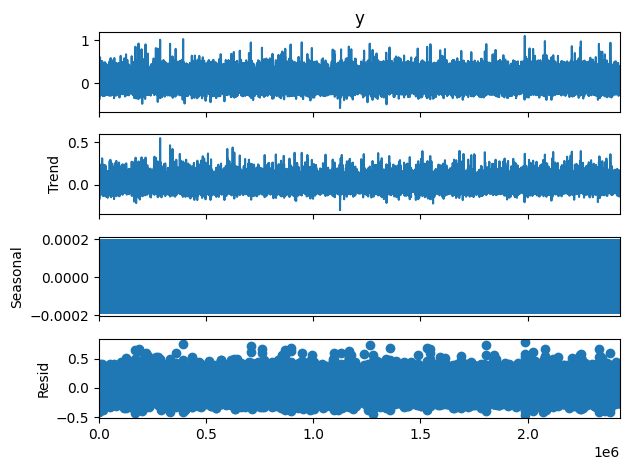

In [26]:
result.plot()
plt.show()

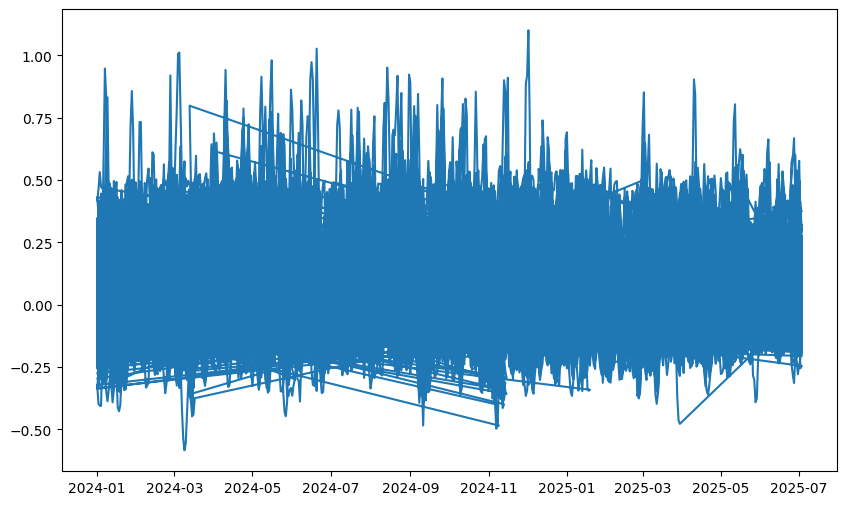

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['y'], label='y')
plt.show()
#codes = df['code']
#for codes in df['code']:
#    plt.plot(df[df['code'] == codes]['y'])
#plt.plot(df[df['code'] == 's_0']['y'])

In [28]:
df.head()

code       date       f_0       f_1       f_2  f_3       f_4       f_5  f_6  \
0  s_0 2024-05-01  0.394700 -0.063500  7.562500  0.0  0.048135  0.582772  0.0   
1  s_0 2024-05-02  0.302114 -0.039620  7.562500  0.0  0.003498  0.571028  0.0   
2  s_0 2024-05-03  0.210442 -0.021979  7.562500  0.0 -0.035704  0.566825  0.0   
3  s_0 2024-05-04  0.091796 -0.014817  7.562500  0.0 -0.073599  0.562066  0.0   
4  s_0 2024-05-05 -0.000065 -0.010519  9.651191  0.0 -0.105692  0.548534  0.0   

        f_7  f_8       f_9  f_10  f_11      f_12      f_13      f_14  \
0  1.952015  0.0  0.933833   0.0   0.0  1.452481  0.000000  0.000000   
1  1.718900  0.0  0.921778   0.0   0.0  1.322955  0.000000  0.000000   
2  1.529921  0.0  0.915979   0.0   0.0  1.203602  0.000000  0.000000   
3  1.483651  0.0  0.919647   0.0   0.0  1.197761  0.000000  0.000000   
4  1.482967  0.0  0.921448   0.0   0.0  1.224910 -0.017885 -0.032768   

       f_15      f_16      f_17      f_18  f_19         y  code_id  
0  0.000000  0.130791  0.000070 -0.009330   0.0 -0.046793        0  
1  0.007457  0.132136  0.000037 -0.000959   0.0 -0.001007        0  
2  0.017134  0.121744  0.000026  0.024070   0.0  0.057230        0  
3  0.030256  0.115516 -0.000006  0.030045   0.0 -0.018251        0  
4  0.040731  0.103038 -0.000039  0.023343   0.0 -0.038166        0

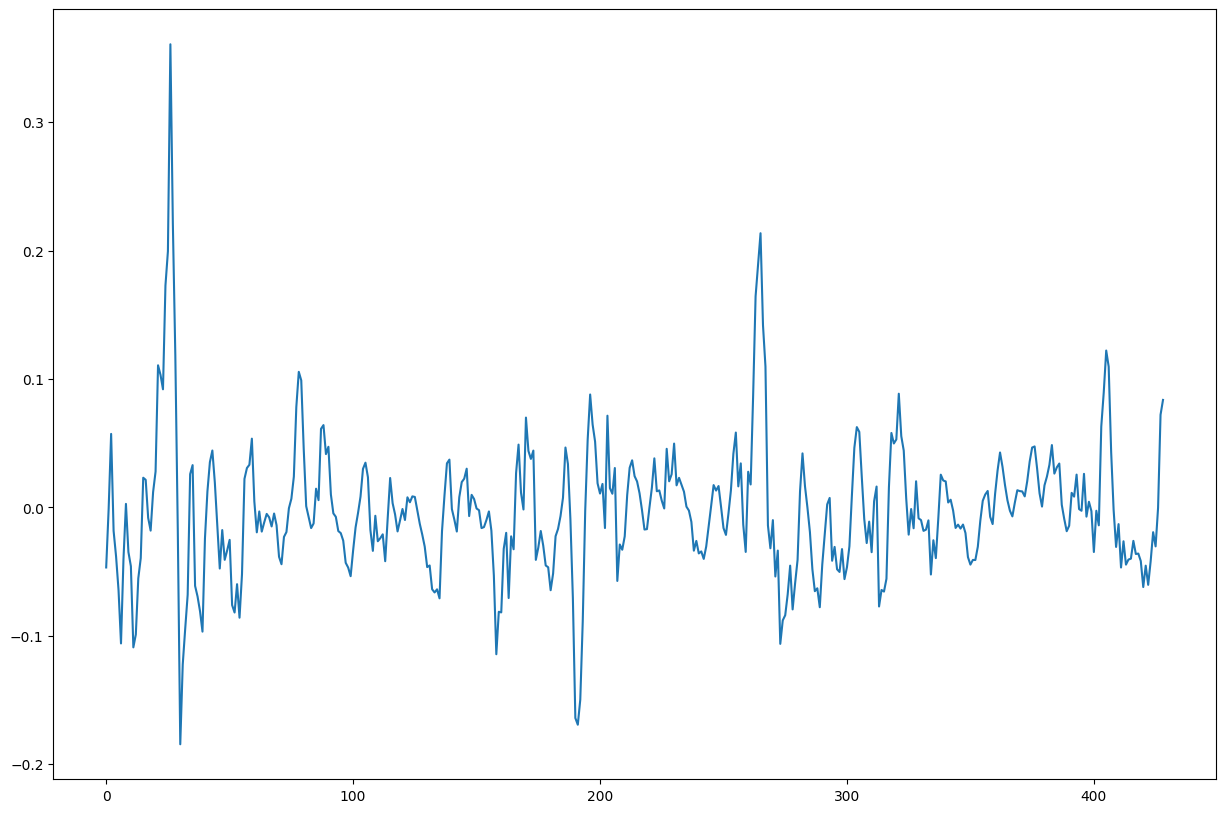

In [29]:
plt.figure(figsize=(15,10))
#codes = df['code']
#for codes in df['code']:
#    plt.plot(df[df['code'] == codes]['y'])
plt.plot(df[df['code'] == 's_0']['y'])

In [110]:
#acf_org = plot_acf(df)
#acf_org = plot_pacf(df)

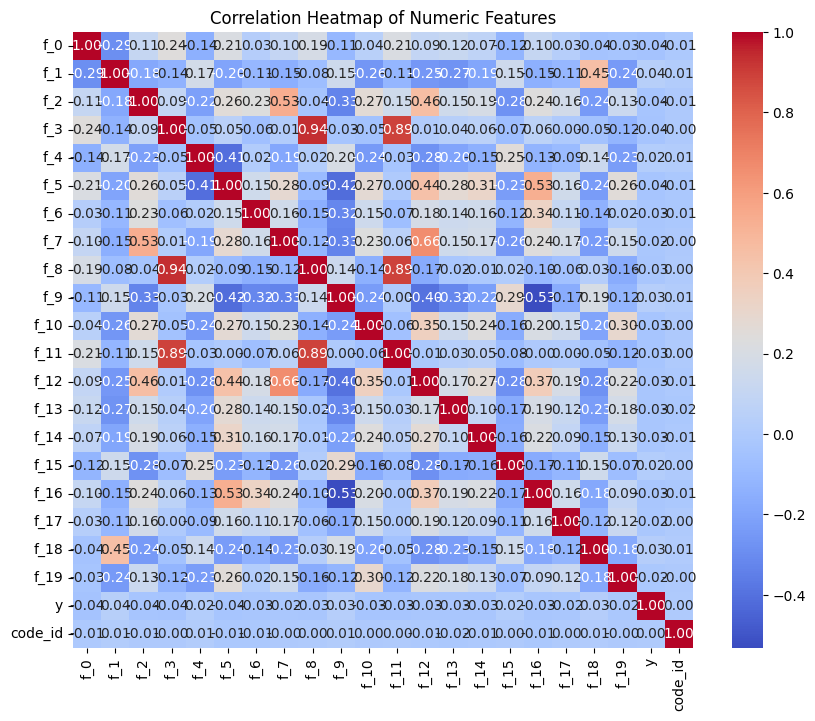

In [13]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number]) # df[df['Department'] == 'Marketing']
#corr = numeric_df.groupby("code").corr()
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

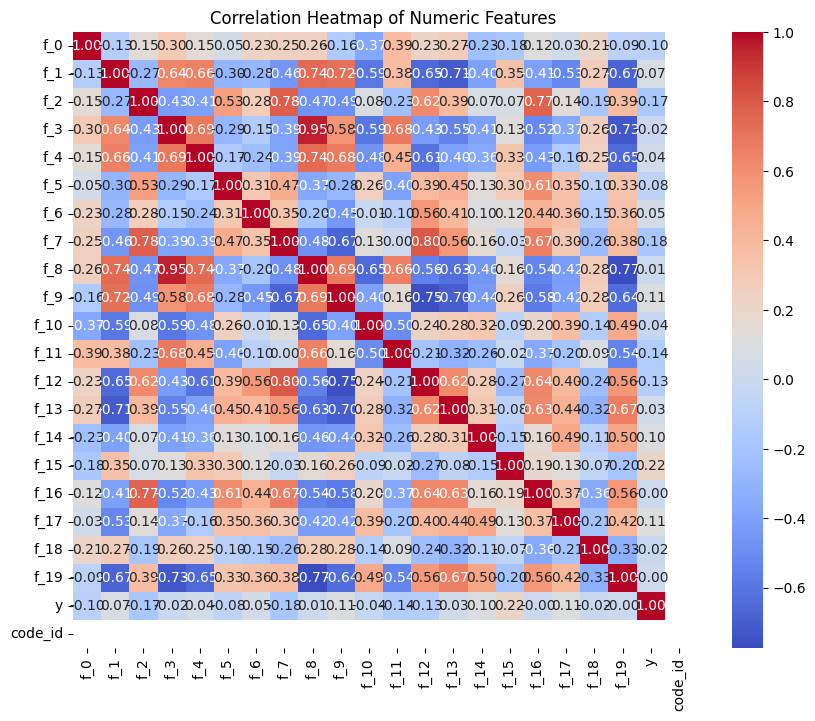

In [14]:
#for c in df['code']:
plt.figure(figsize=(10, 8))
numeric_df = df[df['code'] == 's_0'].select_dtypes(include=[np.number]) # df[df['Department'] == 'Marketing']
#corr = numeric_df.groupby("code").corr()
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [ ]:
corr_threshold = 0.7
for cdi in df['code']:    
    numeric_df = df[df['code'] == cdi].select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    filtered_matrix = corr[((corr >= corr_threshold) | (corr <= -corr_threshold)) & (corr != 1.000)].drop
    print(f"\n :", filtered_matrix)

In [74]:
feature_cols = [c for c in df.columns if c.startswith("f_")]

In [453]:
#feature_cols

In [107]:
sample = df.loc[:, feature_cols + ["y"]].sample(
    n=min(250_000, df.shape[0]), random_state=42
)

In [108]:
corrs = sample[feature_cols].corrwith(sample["y"]).abs().sort_values(ascending=False)
sel_ft = corrs.head(12).index.tolist()
print("Selected f_* features:", sel_ft)

Selected f_* features: ['f_0', 'f_1', 'f_3', 'f_2', 'f_10', 'f_5', 'f_11', 'f_14', 'f_12', 'f_9', 'f_18', 'f_6']


In [360]:
def features_def(df: pd.DataFrame, daily_means=None):
    df = df.copy()
    df["dow"] = df["date"].dt.dayofweek.astype(np.int16)
    df["dom"] = df["date"].dt.day.astype(np.int16)
    df["month"] = df["date"].dt.month.astype(np.int16)
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(np.int16)
    df["year"] = df["date"].dt.year.astype(np.int16)

    #df["date"] = df["date"].astype('int64').astype('int16')
#    df["code"] = df["code"].astype("category")
    df[feature_cols] = df[feature_cols].astype(np.float32)

    df = df.sort_values(["code", "date"], kind="mergesort").reset_index(drop=True)
    Xf = df[feature_cols].to_numpy(dtype=np.float32)
    df["f_mean"]  = Xf.mean(axis=1)
    df["f_std"]   = Xf.std(axis=1)
    df["f_min"]   = Xf.min(axis=1)
    df["f_max"]   = Xf.max(axis=1)
    df["f_range"] = (df["f_max"] - df["f_min"]).astype(np.float32)

    df_dt= df["date"].copy()
    df_dt["date"] = df["date"].astype('int64').astype('int16')
    d = df_dt["date"].to_numpy()
    PERIODS = [7, 30, 90, 365]
    for p in PERIODS:
        df[f"date_sin_{p}"]  = np.sin(2 * np.pi * d / p).astype(np.float32)
        df[f"date_cos_{p}"]  = np.cos(2 * np.pi * d / p).astype(np.float32)
        
    df["y"] = df["y"].astype(np.float32)
    g = df.groupby("code", observed=True, sort=False)["y"]

    df["y_lag1"] = g.shift(1)
    df["y_lag2"] = g.shift(2)
    df["y_lag3"] = g.shift(3)
    df["y_lag5"] = g.shift(5)

    y_shift1 = g.shift(1)
    df["y_roll_mean_5"] = (
        y_shift1.groupby(df["code"], observed=True, sort=False)
        .rolling(5, min_periods=3).mean()
        .reset_index(level=0, drop=True)
    )
    df["y_roll_mean_20"] = (
        y_shift1.groupby(df["code"], observed=True, sort=False)
        .rolling(20, min_periods=10).mean()
        .reset_index(level=0, drop=True)
    )
    df["y_roll_std_20"] = (
        y_shift1.groupby(df["code"], observed=True, sort=False)
        .rolling(20, min_periods=10).std()
        .reset_index(level=0, drop=True)
    )
    target_col="y"
    feat_cols = [c for c in df.columns if c not in ["code", "date", target_col]]
    return df, feat_cols, daily_means


In [16]:
#df['f_3'].describe()
#df['f_8'].describe()

In [17]:
#df.drop(['f_8'], axis=1, inplace=True)

In [312]:
#base_feats = [c for c in df.columns if c.startswith("f_")]
#print("Rows:", len(df), " | Series:", df["code"].nunique(), " | Base features:", len(base_feats))
#df.head()

In [22]:
#df["t_idx"] = df.groupby("code").cumcount().astype(np.int32)

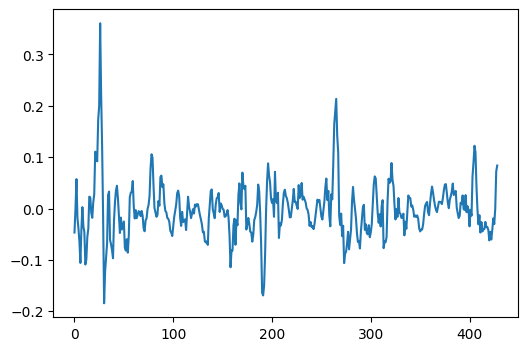

In [35]:
plt.figure(figsize=(6,4))
#codes = df['code']
#for codes in df['code']:
#    plt.plot(df[df['code'] == codes]['y'])
plt.plot(df[df['code'] == 's_0']['y'])

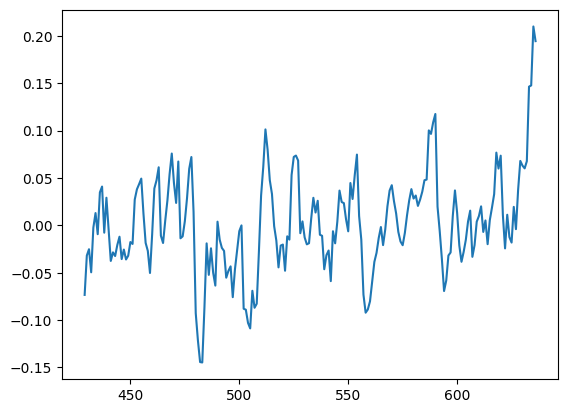

In [36]:
plt.plot(df[df['code'] == 's_1']['y'])

In [111]:
unique_dates = np.array(sorted(df["date"].unique()))

In [112]:
cut = int(math.floor(len(unique_dates) * 0.8))
cut_date = unique_dates[cut]
cut_date

Timestamp('2025-03-16 00:00:00')

In [113]:
df_t = df[df["date"] < cut_date].copy()
df_v  = df[df["date"] >= cut_date].copy()

print("Cut date:", pd.to_datetime(cut_date).date())
print("Train rows:", len(df_t), "Validation rows:", len(df_v))

Cut date: 2025-03-16
Train rows: 1906350 Validation rows: 525308


In [114]:
df_t[feature_cols].head()

f_0       f_1       f_2  f_3       f_4       f_5  f_6       f_7  f_8  \
0  0.394700 -0.063500  7.562500  0.0  0.048135  0.582772  0.0  1.952015  0.0   
1  0.302114 -0.039620  7.562500  0.0  0.003498  0.571028  0.0  1.718900  0.0   
2  0.210442 -0.021979  7.562500  0.0 -0.035704  0.566825  0.0  1.529921  0.0   
3  0.091796 -0.014817  7.562500  0.0 -0.073599  0.562066  0.0  1.483651  0.0   
4 -0.000065 -0.010519  9.651191  0.0 -0.105692  0.548534  0.0  1.482967  0.0   

        f_9  f_10  f_11      f_12      f_13      f_14      f_15      f_16  \
0  0.933833   0.0   0.0  1.452481  0.000000  0.000000  0.000000  0.130791   
1  0.921778   0.0   0.0  1.322955  0.000000  0.000000  0.007457  0.132136   
2  0.915979   0.0   0.0  1.203602  0.000000  0.000000  0.017134  0.121744   
3  0.919647   0.0   0.0  1.197761  0.000000  0.000000  0.030256  0.115516   
4  0.921448   0.0   0.0  1.224910 -0.017885 -0.032768  0.040731  0.103038   

       f_17      f_18  f_19  
0  0.000070 -0.009330   0.0  
1  0.000037 -0.000959   0.0  
2  0.000026  0.024070   0.0  
3 -0.000006  0.030045   0.0  
4 -0.000039  0.023343   0.0

In [73]:
df_v.index

Index([    319,     320,     321,     322,     323,     324,     325,     326,
           327,     328,
       ...
       2431648, 2431649, 2431650, 2431651, 2431652, 2431653, 2431654, 2431655,
       2431656, 2431657],
      dtype='int64', length=525308)

In [116]:
train_df, f_cols, daily_means_train = features_def(df_t)

In [123]:
Xt_df = train_df[f_cols].dropna()

In [130]:
yt_df = train_df['y']

In [127]:
valid_df, f_cols, daily_means_valid = features_def(df_v)

In [128]:
Xv_df = valid_df[f_cols].dropna()

In [131]:
yv_df = valid_df['y']

In [148]:
X_row = Xt_df.to_numpy(dtype=np.float32)
y_row = yt_df.to_numpy(dtype=np.float32)

In [149]:
#imputing Missing Values
imp_mi = SimpleImputer(strategy="median")
X_row_imp = imp_mi.fit_transform(X_row)

In [150]:
mi_xr = X_row.copy()
mi_yr = y_row.copy()

In [151]:
np.isnan(mi_xr).any() #mi_xr.isnull().sum()

np.False_

In [48]:
from sklearn.feature_selection import SelectKBest

In [50]:
#selector = SelectKBest(score_func=mutual_info_regression, k=25)
#selector.fit(mi_xr,mi_yr)

In [43]:
#select_feaures_indixes=selector.get_support(indices=True)

In [44]:
#select_feaures_indixes

array([ 0,  2, 12, 17, 20, 21, 22, 23, 24, 25, 26, 29, 30, 33, 34])

In [52]:
#colnames = df.columns[select_feaures_indixes]
#print(colnames)

In [152]:
rng = np.random.default_rng(42)
n_sample = min(20000, X_row_imp.shape[0])
idx = rng.choice(X_row_imp.shape[0], size=n_sample, replace=False)

In [154]:
mi = mutual_info_regression(X_row_imp[idx], y_row[idx], random_state=42)
mi_series = pd.Series(mi, index=f_cols).sort_values(ascending=False)

In [156]:
TOP_K = min(25, len(f_cols))
selected_features = mi_series.head(TOP_K).index.tolist()
mi_series.head(20)

code_id          0.013934
t_idx            0.010315
f_mean           0.009971
f_3              0.005555
f_11             0.004979
y_lag3           0.004936
dow              0.004114
f_17             0.003486
f_5              0.003176
y_lag1           0.003162
f_4              0.002769
f_14             0.002682
f_7              0.001989
y_roll_mean_5    0.001405
f_std            0.001086
date_cos_365     0.000192
year             0.000167
date_cos_7       0.000152
date_sin_30      0.000124
f_range          0.000104
dtype: float64

In [216]:
#selected_features

In [159]:
X_train_row = train_df[selected_features].to_numpy(dtype=np.float32)
X_valid_row  = valid_df[selected_features].to_numpy(dtype=np.float32)

In [160]:
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()

In [161]:
X_train_imp = imp.fit_transform(X_train_row)
X_valid_imp  = imp.transform(X_valid_row)

In [162]:
X_train_scaled = scaler.fit_transform(X_train_imp)
X_valid_scaled  = scaler.transform(X_valid_imp)

In [163]:
X_train_scaled.shape[1]

25

In [164]:
PCA_N = min(20, X_train_scaled.shape[1])
pca = PCA(n_components=PCA_N, random_state=42)

In [165]:
Z_train = pca.fit_transform(X_train_scaled).astype(np.float32)
Z_valid  = pca.transform(X_valid_scaled).astype(np.float32)

In [166]:
kmeans = MiniBatchKMeans(n_clusters=8, random_state=42, batch_size=4096, n_init="auto")
kmeans.fit(Z_train)

MiniBatchKMeans(batch_size=4096, random_state=42)

In [167]:
D_train = kmeans.transform(Z_train).astype(np.float32)  # distances to centers
D_valid  = kmeans.transform(Z_valid).astype(np.float32)

In [67]:
D_train

array([[11.874621 , 10.422869 , 12.344367 , ..., 12.459385 , 13.310226 ,
        12.38592  ],
       [11.317198 ,  9.895018 , 11.753285 , ..., 11.901919 , 12.713357 ,
        11.81431  ],
       [10.882619 ,  9.50218  , 11.2728615, ..., 11.46059  , 12.214427 ,
        11.359136 ],
       ...,
       [ 4.6081967,  5.562    ,  4.6808085, ...,  4.64226  ,  4.1049824,
         4.2950535],
       [ 4.7922645,  5.7081227,  4.9266815, ...,  4.7623005,  4.4056706,
         4.517005 ],
       [ 4.623038 ,  5.5286107,  4.858165 , ...,  4.5615826,  4.3889966,
         4.3949533]], shape=(1906350, 8), dtype=float32)

In [168]:
F_train = np.hstack([Z_train, D_train]).astype(np.float32)
F_valid  = np.hstack([Z_valid,  D_valid]).astype(np.float32)

print("Row feature matrix shapes:", F_train.shape, F_valid.shape)

Row feature matrix shapes: (1906350, 28) (525308, 28)


In [70]:
df_ftrain = pd.DataFrame(F_train)
df_fvalid = pd.DataFrame(F_valid)

In [71]:
df_ftrain.head()


0         1         2         3         4         5         6   \
0 -5.449065  5.130941  2.465398 -0.235900  0.364163  0.965113 -0.929550   
1 -5.087369  4.701354  2.377216 -0.363964  0.487662  1.463763 -0.395853   
2 -4.728393  4.281799  2.297202 -0.511723  0.563472  1.592037 -0.091787   
3 -4.594130  4.079570  2.222747 -0.658020  0.589466  1.254034 -0.188599   
4 -5.414742  4.959234  2.829867 -0.671244  0.313689  0.514996 -0.718642   

         7         8         9         10        11        12         13  \
0 -0.291819 -2.549440 -1.840019  1.228204 -0.403127 -2.441375   8.100534   
1  0.613230 -2.009827 -1.921808  1.249031 -0.271701 -2.259551   7.908681   
2  0.802243 -1.602168 -1.784525  1.293415 -0.145632 -2.070684   7.770021   
3  0.118021 -1.482612 -2.026384  1.356118  0.108847 -2.158938   7.883276   
4 -0.837522 -2.605773 -3.227036  2.854483 -0.059216 -2.616198  10.208289   

         14         15         16         17         18         19         20  \
0  0.713971  11.874621  10.422869  12.344367  13.170129  12.886845  12.459385   
1 -0.244066  11.317198   9.895018  11.753285  12.595353  12.254445  11.901919   
2 -1.041667  10.882619   9.502180  11.272861  12.127402  11.725140  11.460590   
3 -1.035918  10.822798   9.491137  11.176749  12.052040  11.627261  11.396814   
4 -2.153582  14.075838  12.856122  14.458765  15.230756  14.803296  14.640014   

          21         22  
0  13.310226  12.385920  
1  12.713357  11.814310  
2  12.214427  11.359136  
3  12.106799  11.271142  
4  15.266923  14.587021

In [72]:
df_fvalid.shape

(525308, 23)

In [74]:
#train_gen = F_train.copy()

In [73]:
#TS Generator
#n_input = 30
#n_features = 23
#generator = TimeseriesGenerator(train_gen, train_gen, length=n_input, batch_size=256)

In [76]:
#X,y = generator[0]

In [78]:
#print(f'X:{X.flatten()}')
#print(f'y:{y.flatten()}')

In [103]:
#model = Sequential()
#model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
#model.add(LSTM(32))
#model.add(LSTM(32, activation='relu', input_shape=(n_input, n_features)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

In [79]:
#model.summary()

In [80]:
#model.fit(generator, epochs=50)

In [81]:
train_df.head()

code       date       f_0       f_1       f_2  f_3       f_4       f_5  f_6  \
0  s_0 2024-05-01  0.394700 -0.063500  7.562500  0.0  0.048135  0.582772  0.0   
1  s_0 2024-05-02  0.302114 -0.039620  7.562500  0.0  0.003498  0.571028  0.0   
2  s_0 2024-05-03  0.210442 -0.021979  7.562500  0.0 -0.035704  0.566825  0.0   
3  s_0 2024-05-04  0.091796 -0.014817  7.562500  0.0 -0.073599  0.562066  0.0   
4  s_0 2024-05-05 -0.000065 -0.010519  9.651191  0.0 -0.105692  0.548534  0.0   

        f_7  f_8       f_9  f_10  f_11      f_12      f_13      f_14  \
0  1.952015  0.0  0.933833   0.0   0.0  1.452481  0.000000  0.000000   
1  1.718900  0.0  0.921778   0.0   0.0  1.322955  0.000000  0.000000   
2  1.529921  0.0  0.915979   0.0   0.0  1.203602  0.000000  0.000000   
3  1.483651  0.0  0.919647   0.0   0.0  1.197761  0.000000  0.000000   
4  1.482967  0.0  0.921448   0.0   0.0  1.224910 -0.017885 -0.032768   

       f_15      f_16      f_17      f_18  f_19         y  code_id  t_idx  \
0  0.000000  0.130791  0.000070 -0.009330   0.0 -0.046793        0      0   
1  0.007457  0.132136  0.000037 -0.000959   0.0 -0.001007        0      1   
2  0.017134  0.121744  0.000026  0.024070   0.0  0.057230        0      2   
3  0.030256  0.115516 -0.000006  0.030045   0.0 -0.018251        0      3   
4  0.040731  0.103038 -0.000039  0.023343   0.0 -0.038166        0      4   

   dow  dom  month  weekofyear  year     sin_7     cos_7    sin_30    cos_30  \
0    2    1      5          18  2024  0.000000  1.000000  0.000000  1.000000   
1    3    2      5          18  2024  0.781832  0.623490  0.207912  0.978148   
2    4    3      5          18  2024  0.974928 -0.222521  0.406737  0.913545   
3    5    4      5          18  2024  0.433884 -0.900969  0.587785  0.809017   
4    6    5      5          18  2024 -0.433884 -0.900969  0.743145  0.669131   

     sin_90    cos_90   sin_365   cos_365  
0  0.000000  1.000000  0.000000  1.000000  
1  0.069756  0.997564  0.017213  0.999852  
2  0.139173  0.990268  0.034422  0.999407  
3  0.207912  0.978148  0.051620  0.998667  
4  0.275637  0.961262  0.068802  0.997630

In [170]:
SEQ_LEN = 30 

train_df = train_df.sort_values(["code","date"]).reset_index(drop=True)
test_df  = valid_df.sort_values(["code","date"]).reset_index(drop=True)

y_train_row = train_df['y'].to_numpy(dtype=np.float32)
y_valid_row  = valid_df['y'].to_numpy(dtype=np.float32)

In [171]:
def make_sequences_by_code(df_part, feats_array, y_array, seq_len=30):
    Xs, ys, meta = [], [], []
    for code, grp in df_part.groupby("code", sort=False):
        idx = grp.index.to_numpy()
        feat = feats_array[idx]
        y = y_array[idx] #if y_array is not None else None
        for i in range(seq_len, len(idx)):
            Xs.append(feat[i-seq_len:i])
#            if y is not None:
            ys.append(y[i])
            meta.append((code, grp.loc[idx[i], "date"]))
    Xs = np.asarray(Xs, dtype=np.float32)
    meta = pd.DataFrame(meta, columns=["code","date"])
#    if y_array is None:
#        return Xs, meta
    ys = np.asarray(ys, dtype=np.float32)
    return Xs, ys, meta

In [173]:
X_seq, y_seq, meta_train = make_sequences_by_code(train_df, F_train, y_train_row, seq_len=SEQ_LEN)
Xh_seq, yh_seq, meta_valid = make_sequences_by_code(valid_df, F_valid, y_valid_row, seq_len=SEQ_LEN)

print("Train sequences:", X_seq.shape, "Validation sequences:", Xh_seq.shape)

Train sequences: (1762924, 30, 28) Validation sequences: (380741, 30, 28)


In [95]:
X_seq = X_seq[sort_idx]
y_seq = y_seq[sort_idx]
meta_train = meta_train.iloc[sort_idx].reset_index(drop=True)

val_cut = int(len(X_seq) * 0.85)
X_tr, X_val = X_seq[:val_cut], X_seq[val_cut:]
y_tr, y_val = y_seq[:val_cut], y_seq[val_cut:]

print("Train/Val:", X_tr.shape, X_val.shape)

code            object
date    datetime64[ns]
dtype: object

In [96]:
meta_train = meta_train.copy()
#meta_train["date"] = pd.to_datetime(meta_train["date"])
sort_idx = np.argsort(meta_train["date"].to_numpy())

In [174]:
tf.random.set_seed(42)
np.random.seed(42)

model = models.Sequential([
    layers.Input(shape=(X_seq.shape[1], X_seq.shape[2])),
    layers.LSTM(96, return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(48),
    layers.Dropout(0.25),
    layers.Dense(1)
])

model.compile(optimizer=optimizers.Adam(learning_rate=.006), loss="mse")

es = callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_loss")

In [175]:
hist = model.fit(
    X_seq, y_seq,
    validation_data=(Xh_seq, yh_seq),
    epochs=30,
    batch_size=256,
    callbacks=[es],
    verbose=0
)

In [176]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 96)              │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 48)                  │          27,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227,669 (889.34 KB)

 Trainable params: 75,889 (296.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 151,780 (592.89 KB)

In [184]:
print(hist.history.keys())

dict_keys(['loss', 'val_loss'])


In [182]:
training_loss = hist.history['loss']
print(training_loss)

[0.003082041395828128, 0.002003313275054097, 0.001965660136193037, 0.0019294869853183627, 0.0019069844856858253]


In [187]:
validation_loss = hist.history['val_loss']
print(validation_loss)

[0.001237130374647677, 0.00133127486333251, 0.0014500035904347897, 0.0014122800203040242, 0.0014523371355608106]


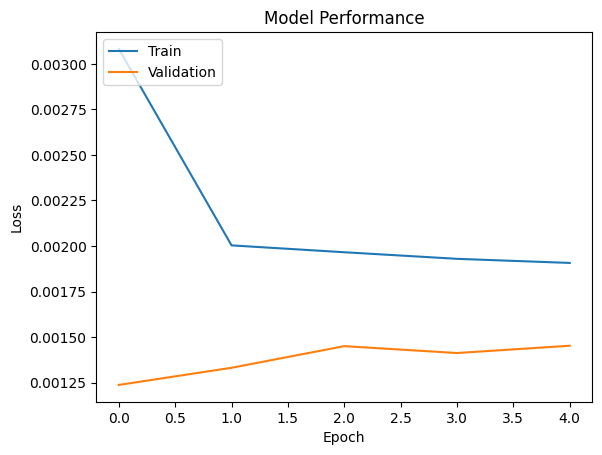

In [191]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [188]:
pred_val = model.predict(Xh_seq, verbose=0).ravel()
rmse = mean_squared_error(yh_seq, pred_val)
mae  = mean_absolute_error(yh_seq, pred_val)
#results.append({"val_rmse": float(rmse), "val_mae": float(mae), "epochs": len(hist.history["loss"])})

print("Validation RMSE:", rmse, "Validation MAE:", mae)

Validation RMSE: 0.0012371307238936424 Validation MAE: 0.025131698697805405


In [ ]:
#pd.DataFrame(results).sort_values("val_rmse")

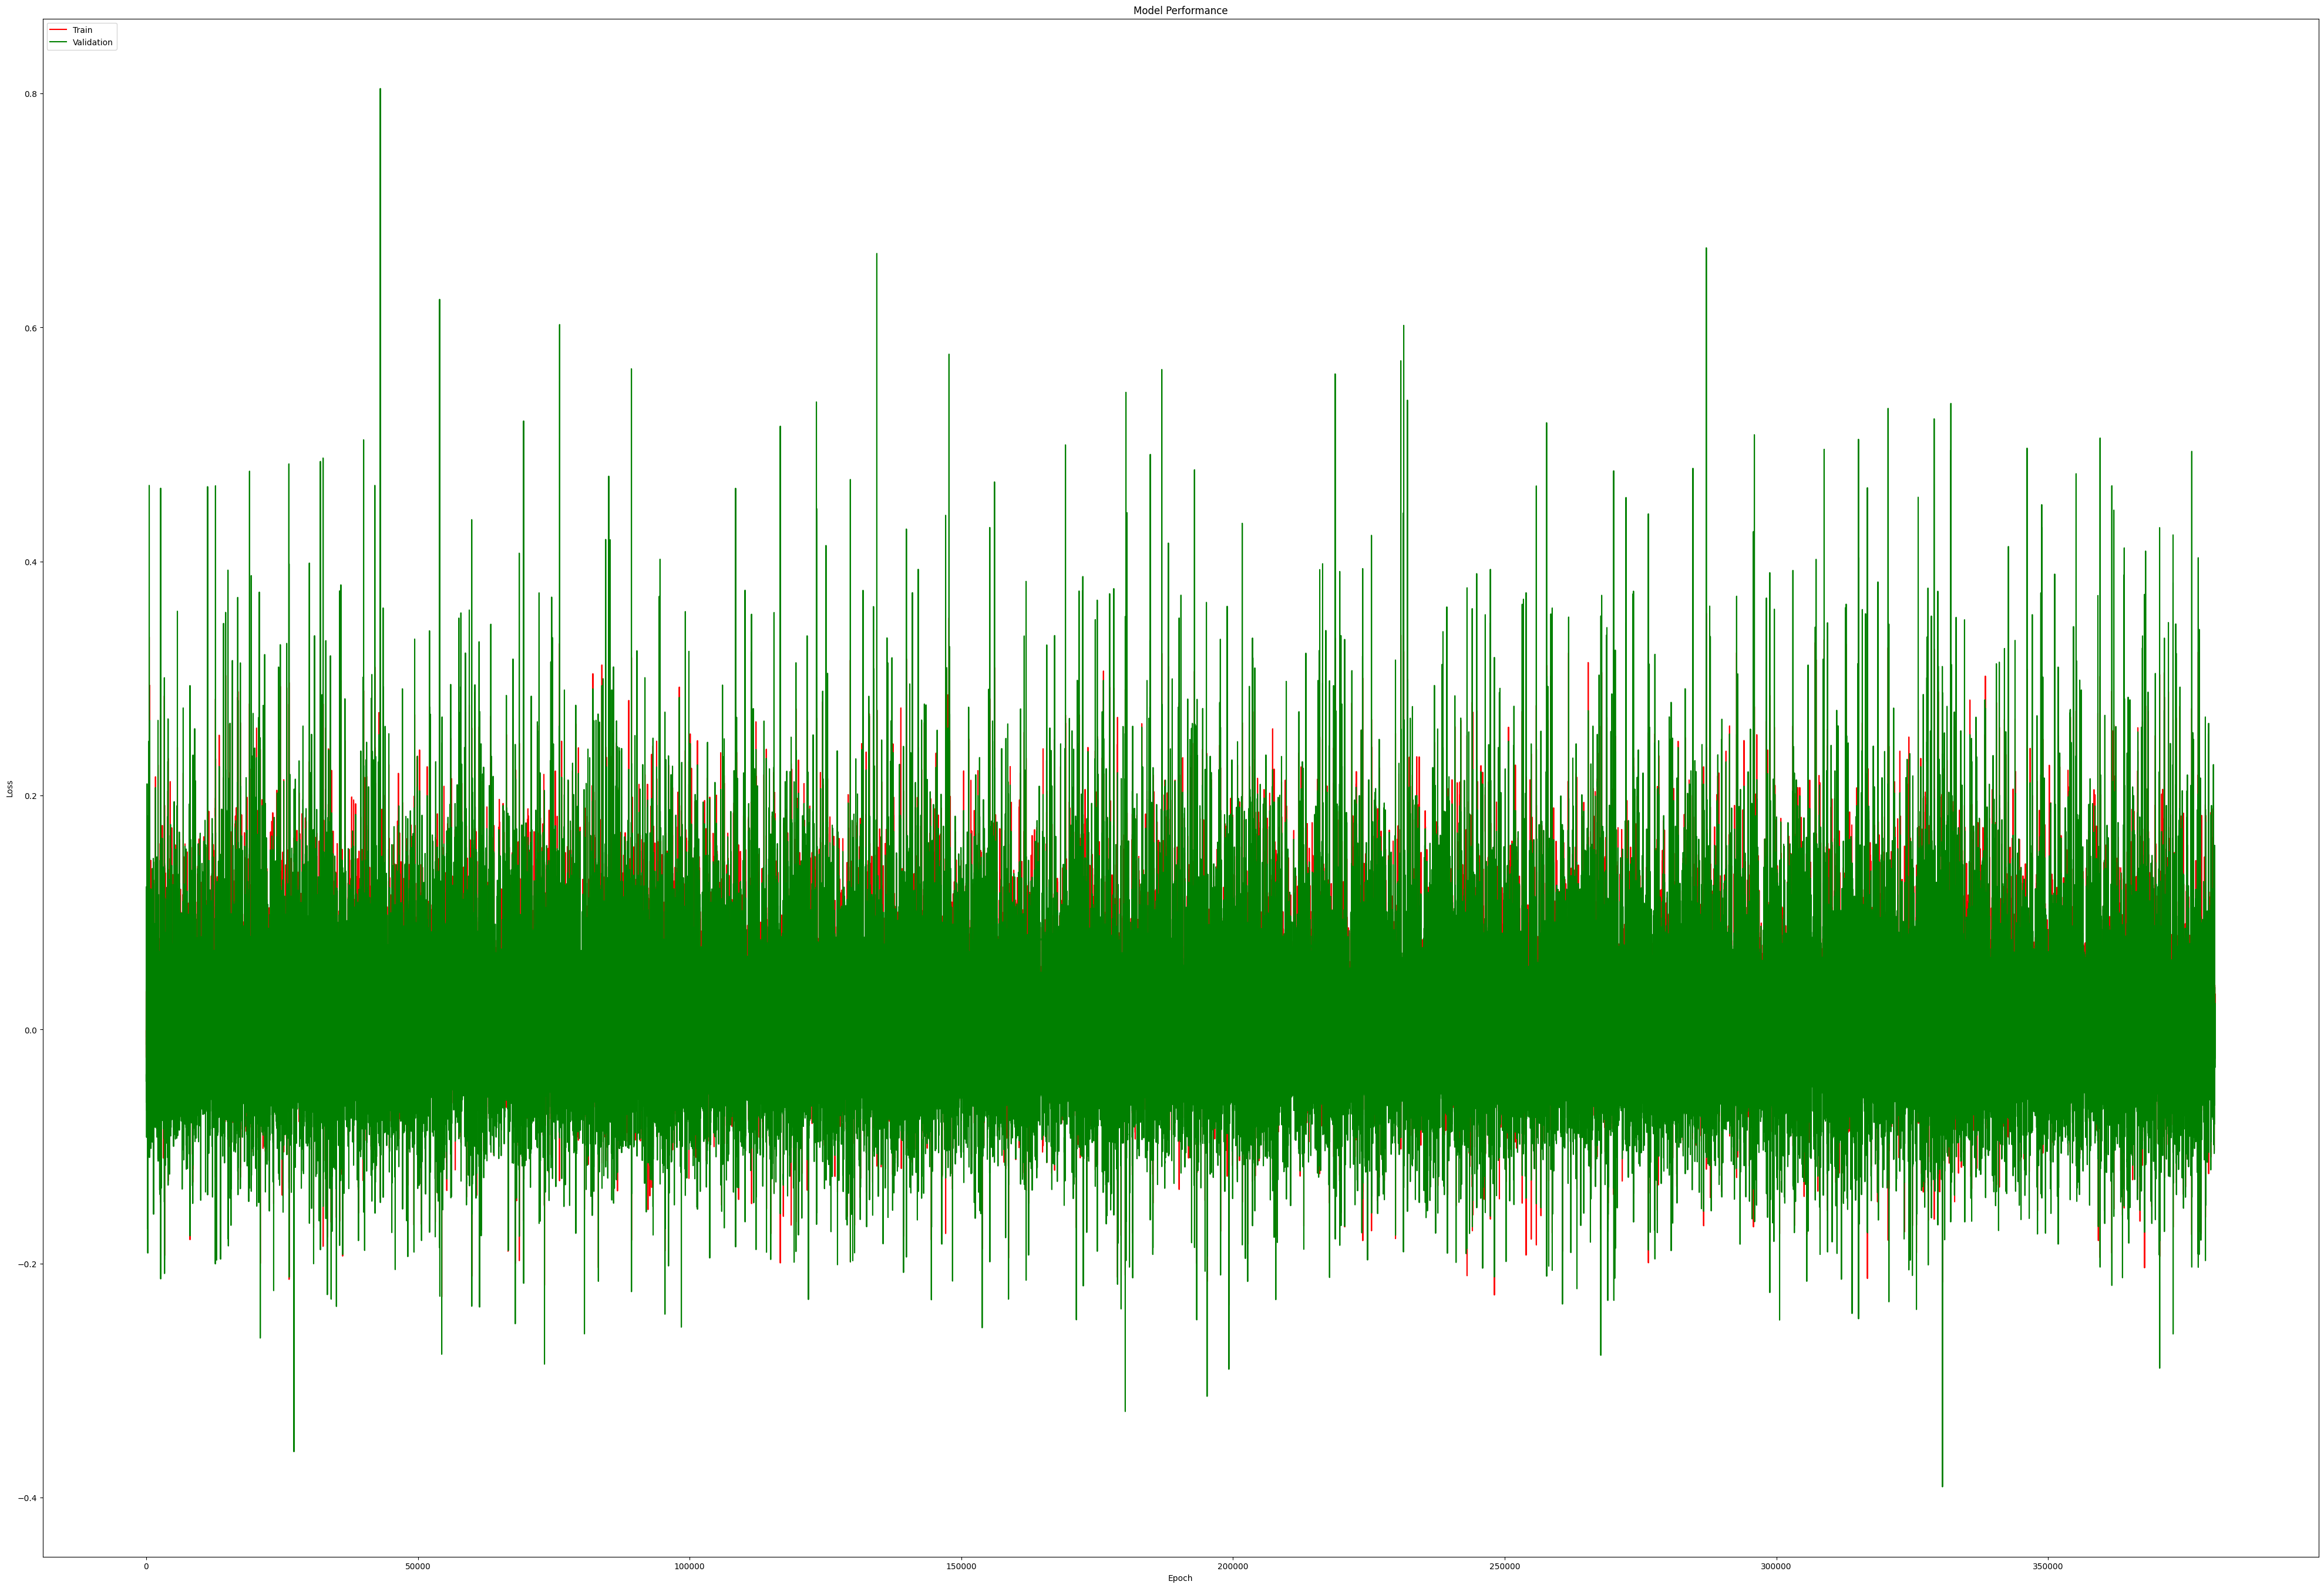

In [201]:
plt.figure(figsize=(50,34))
plt.plot(pred_val, color='red')
plt.plot(yh_seq, color='green')
plt.title('Model Performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [118]:
"""pred_val_df = meta_valid.copy()
pred_val_df["date"] = pd.to_datetime(pred_val_df["date"]).dt.strftime("%Y-%m-%d")
pred_val_df["y_true"] = yh_seq
pred_val_df["y_pred"] = pred_val"""

'pred_val_df = meta_valid.copy()\npred_val_df["date"] = pd.to_datetime(pred_val_df["date"]).dt.strftime("%Y-%m-%d")\npred_val_df["y_true"] = yh_seq\npred_val_df["y_pred"] = pred_val'

In [345]:
df_test = tstData.copy()

In [315]:
df_test.shape

(869269, 23)

In [346]:
df_test['date'] = pd.to_datetime(df_test['date'], unit='D', origin='2024-01-01')

In [317]:
#df_test["date"] = pd.to_datetime(df_test["date"])

In [348]:
df_test.head()

code       date       f_0       f_1       f_2       f_3       f_4  \
2244974  s_4780 2025-07-04 -0.704179  0.072523  1.990935  0.820878 -0.006093   
2031851  s_2097 2025-07-04 -1.475341 -0.060034  1.737305  0.675257  0.101021   
2433999  s_2157 2025-07-04 -1.577786  0.074787  1.659307  0.696049  0.076902   
2402607  s_4105 2025-07-04 -1.003856  0.033389  1.360022  0.586838 -0.026944   
1952904  s_2387 2025-07-04 -1.260005 -0.068659  2.414646  0.838523 -0.094169   

              f_5       f_6       f_7       f_8       f_9      f_10      f_11  \
2244974  0.485911  0.040129  0.942753  2.119506  0.934240  0.081470  1.129677   
2031851  0.273800  0.003186  0.834724  2.751153  0.976950  0.003297  1.146666   
2433999  0.304876 -0.016647  0.804080  3.097071  0.981946  0.015689  1.223102   
2402607  0.450235  0.019490  0.848843  2.781379  0.958969 -0.001349  1.153103   
1952904  0.335265  0.001841  0.893063  2.625780  0.928790  0.057546  1.016474   

             f_12      f_13      f_14      f_15      f_16      f_17      f_18  \
2244974  0.949033 -0.058095  0.016745  0.002501  0.080117 -0.000019 -0.003881   
2031851  0.872422 -0.089398  0.022010 -0.048870  0.016602 -0.000008  0.040727   
2433999  0.803156 -0.053105 -0.016663 -0.046717 -0.015627 -0.000052  0.026963   
2402607  0.940588 -0.052266 -0.015170  0.044854 -0.016701 -0.000013  0.038767   
1952904  0.897439 -0.092461  0.021719  0.010151  0.006536 -0.000028 -0.060134   

             f_19         y  
2244974 -0.030448 -0.106038  
2031851 -0.068891 -0.066604  
2433999  0.002812 -0.011905  
2402607 -0.031813  0.071741  
1952904  0.083079 -0.004084

In [368]:
df_test = df_test.sort_values(["code","date"]).reset_index(drop=True)

In [369]:
df_test["code_id"] = df_test["code"].astype("category").cat.codes.astype(np.int32)
df_test["t_idx"] =df_test.groupby("code").cumcount().astype(np.int32)

In [371]:
test_df, f_cols, daily_means_test = features_def(df_test)

In [372]:
test_df.head()

code       date       f_0       f_1       f_2       f_3       f_4       f_5  \
0  s_0 2025-07-04 -1.369722  0.039572  1.779249  0.614737 -0.156733  0.283154   
1  s_0 2025-07-05 -1.382292  0.046213  1.788899  0.588849 -0.113548  0.281461   
2  s_0 2025-07-06 -1.400969  0.040787  1.945576  0.591494 -0.072045  0.283010   
3  s_0 2025-07-07 -1.374383  0.045059  1.815760  0.600794 -0.066371  0.306641   
4  s_0 2025-07-08 -1.382681  0.038729  1.834345  0.601960 -0.119939  0.273871   

        f_6       f_7       f_8       f_9      f_10      f_11      f_12  \
0  0.028497  0.578046  3.074321  0.980909  0.017531  0.993053  0.722489   
1  0.028017  0.556441  3.054377  0.980679  0.006043  1.012733  0.697357   
2  0.038164  0.582346  3.121780  0.979803  0.003479  1.194460  0.721132   
3  0.038751  0.678451  3.087187  0.972990  0.005802  1.206392  0.775389   
4  0.026979  0.726376  3.081610  0.971104  0.001889  1.209588  0.803587   

       f_13      f_14      f_15      f_16      f_17      f_18      f_19  \
0 -0.183440  0.003627 -0.034966 -0.014534 -0.000058  0.059350 -0.003217   
1 -0.177849  0.007046 -0.046088 -0.013790 -0.000067  0.035671  0.004659   
2 -0.178476  0.009262 -0.038439 -0.011187 -0.000064  0.029482 -0.010477   
3 -0.177323  0.006861 -0.058894 -0.011347 -0.000055  0.027638 -0.011462   
4 -0.183263  0.003685 -0.045593 -0.006697 -0.000054  0.029528 -0.012795   

          y  code_id  t_idx  dow  dom  month  weekofyear  year    f_mean  \
0  0.090807        0      0    4    4      7          27  2025  0.370593   
1  0.075164        0      1    5    5      7          27  2025  0.367740   
2  0.033599        0      2    6    6      7          27  2025  0.391456   
3  0.020968        0      3    0    7      7          28  2025  0.393394   
4 -0.006153        0      4    1    8      7          28  2025  0.392611   

      f_std     f_min     f_max   f_range  date_sin_7  date_cos_7  \
0  0.868186 -1.369722  3.074321  4.444043         0.0         1.0   
1  0.865905 -1.382292  3.054377  4.436668         0.0         1.0   
2  0.898539 -1.400969  3.121780  4.522749         0.0         1.0   
3  0.882723 -1.374383  3.087187  4.461569         0.0         1.0   
4  0.887703 -1.382681  3.081610  4.464291         0.0         1.0   

   date_sin_30  date_cos_30  date_sin_90  date_cos_90  date_sin_365  \
0          0.0          1.0          0.0          1.0           0.0   
1          0.0          1.0          0.0          1.0           0.0   
2          0.0          1.0          0.0          1.0           0.0   
3          0.0          1.0          0.0          1.0           0.0   
4          0.0          1.0          0.0          1.0           0.0   

   date_cos_365    y_lag1    y_lag2    y_lag3  y_lag5  y_roll_mean_5  \
0           1.0       NaN       NaN       NaN     NaN            NaN   
1           1.0  0.090807       NaN       NaN     NaN            NaN   
2           1.0  0.075164  0.090807       NaN     NaN            NaN   
3           1.0  0.033599  0.075164  0.090807     NaN       0.066523   
4           1.0  0.020968  0.033599  0.075164     NaN       0.055134   

   y_roll_mean_20  y_roll_std_20  
0             NaN            NaN  
1             NaN            NaN  
2             NaN            NaN  
3             NaN            NaN  
4             NaN            NaN

In [374]:
Xtest_df = test_df[f_cols].dropna()
ytest_df = test_df['y']

In [375]:
X_test_row = test_df[selected_features].to_numpy(dtype=np.float32)
y_test_row = test_df['y'].to_numpy(dtype=np.float32)
Xtest_df = test_df[f_cols].dropna()
X_test_imp  = imp.transform(X_test_row)
X_test_scaled  = scaler.transform(X_test_imp)
Z_test  = pca.transform(X_test_scaled).astype(np.float32)
D_test  = kmeans.transform(Z_test).astype(np.float32)
F_test  = np.hstack([Z_test,  D_test]).astype(np.float32)

In [376]:
Xtest_seq, ytest_seq, meta_test = make_sequences_by_code(test_df, F_test, y_test_row, seq_len=SEQ_LEN)

In [ ]:
meta_train = meta_train.copy()
#meta_train["date"] = pd.to_datetime(meta_train["date"])
sort_idx = np.argsort(meta_train["date"].to_numpy())

In [177]:
train_df = train_df.sort_values(["code","date"]).reset_index(drop=True)

In [ ]:
#X_seq, y_seq, meta_train = make_sequences_by_code(train_df, F_train, y_train_row, seq_len=SEQ_LEN)

In [179]:
#df_tst =df_tst.sort_values(["code","date"]).reset_index(drop=True)
#Xtest_seq, ytst_seq, meta_test = make_sequences_by_code(df_tst, F_test, y_test_row, seq_len=SEQ_LEN)

In [378]:
pred_test = model.predict(Xtest_seq, verbose=0).ravel()

In [380]:
rmse = mean_squared_error(ytest_seq, pred_test)
mae  = mean_absolute_error(ytest_seq, pred_test)
#results.append({"val_rmse": float(rmse), "val_mae": float(mae), "epochs": len(hist.history["loss"])})

print("Test RMSE:", rmse, "Test MAE:", mae)

Test RMSE: 0.0012366323499009013 Test MAE: 0.024091331288218498


In [413]:
out_df = meta_test.copy()

In [423]:
out_df.head()

code  date    y_pred
0  s_0   580 -0.000981
1  s_0   581  0.042417
2  s_0   582  0.034527
3  s_0   583  0.044746
4  s_0   584  0.018497

In [418]:
out_df['y_pred'] = pred_test

In [389]:
min_date=df['date'].min()

In [403]:
min_date

Timestamp('2024-01-01 00:00:00')

In [404]:
time_d = out_df['date'] - min_date

In [406]:
print(time_d.min())

580 days 00:00:00


In [407]:
days_numeric = time_d / np.timedelta64(1, 'D')

In [415]:
out_df['date'] = pd.to_numeric(days_numeric, downcast='integer')

In [419]:
out_df.head()

code  date    y_pred
0  s_0   580 -0.000981
1  s_0   581  0.042417
2  s_0   582  0.034527
3  s_0   583  0.044746
4  s_0   584  0.018497

In [262]:
#out_df["date"] = pd.to_datetime(out_df["date"]).dt.strftime("%Y-%m-%d")

In [421]:
os.makedirs("outputs", exist_ok=True)
out_path = 'D:\py\predictions_out_test_lstm.csv'
out_df.to_csv(out_path, index=False)
print("Saved:", out_path)
out_df.head()

Saved: D:\py\predictions_out_test_lstm.csv


code  date    y_pred
0  s_0   580 -0.000981
1  s_0   581  0.042417
2  s_0   582  0.034527
3  s_0   583  0.044746
4  s_0   584  0.018497

In [424]:
out_df['y'] = ytest_seq

In [432]:
outs_0=out_df[out_df['code']=='s_0']

In [433]:
outs_0.head()

code  date    y_pred         y
0  s_0   580 -0.000981  0.042150
1  s_0   581  0.042417  0.083155
2  s_0   582  0.034527  0.053262
3  s_0   583  0.044746  0.000722
4  s_0   584  0.018497 -0.032241

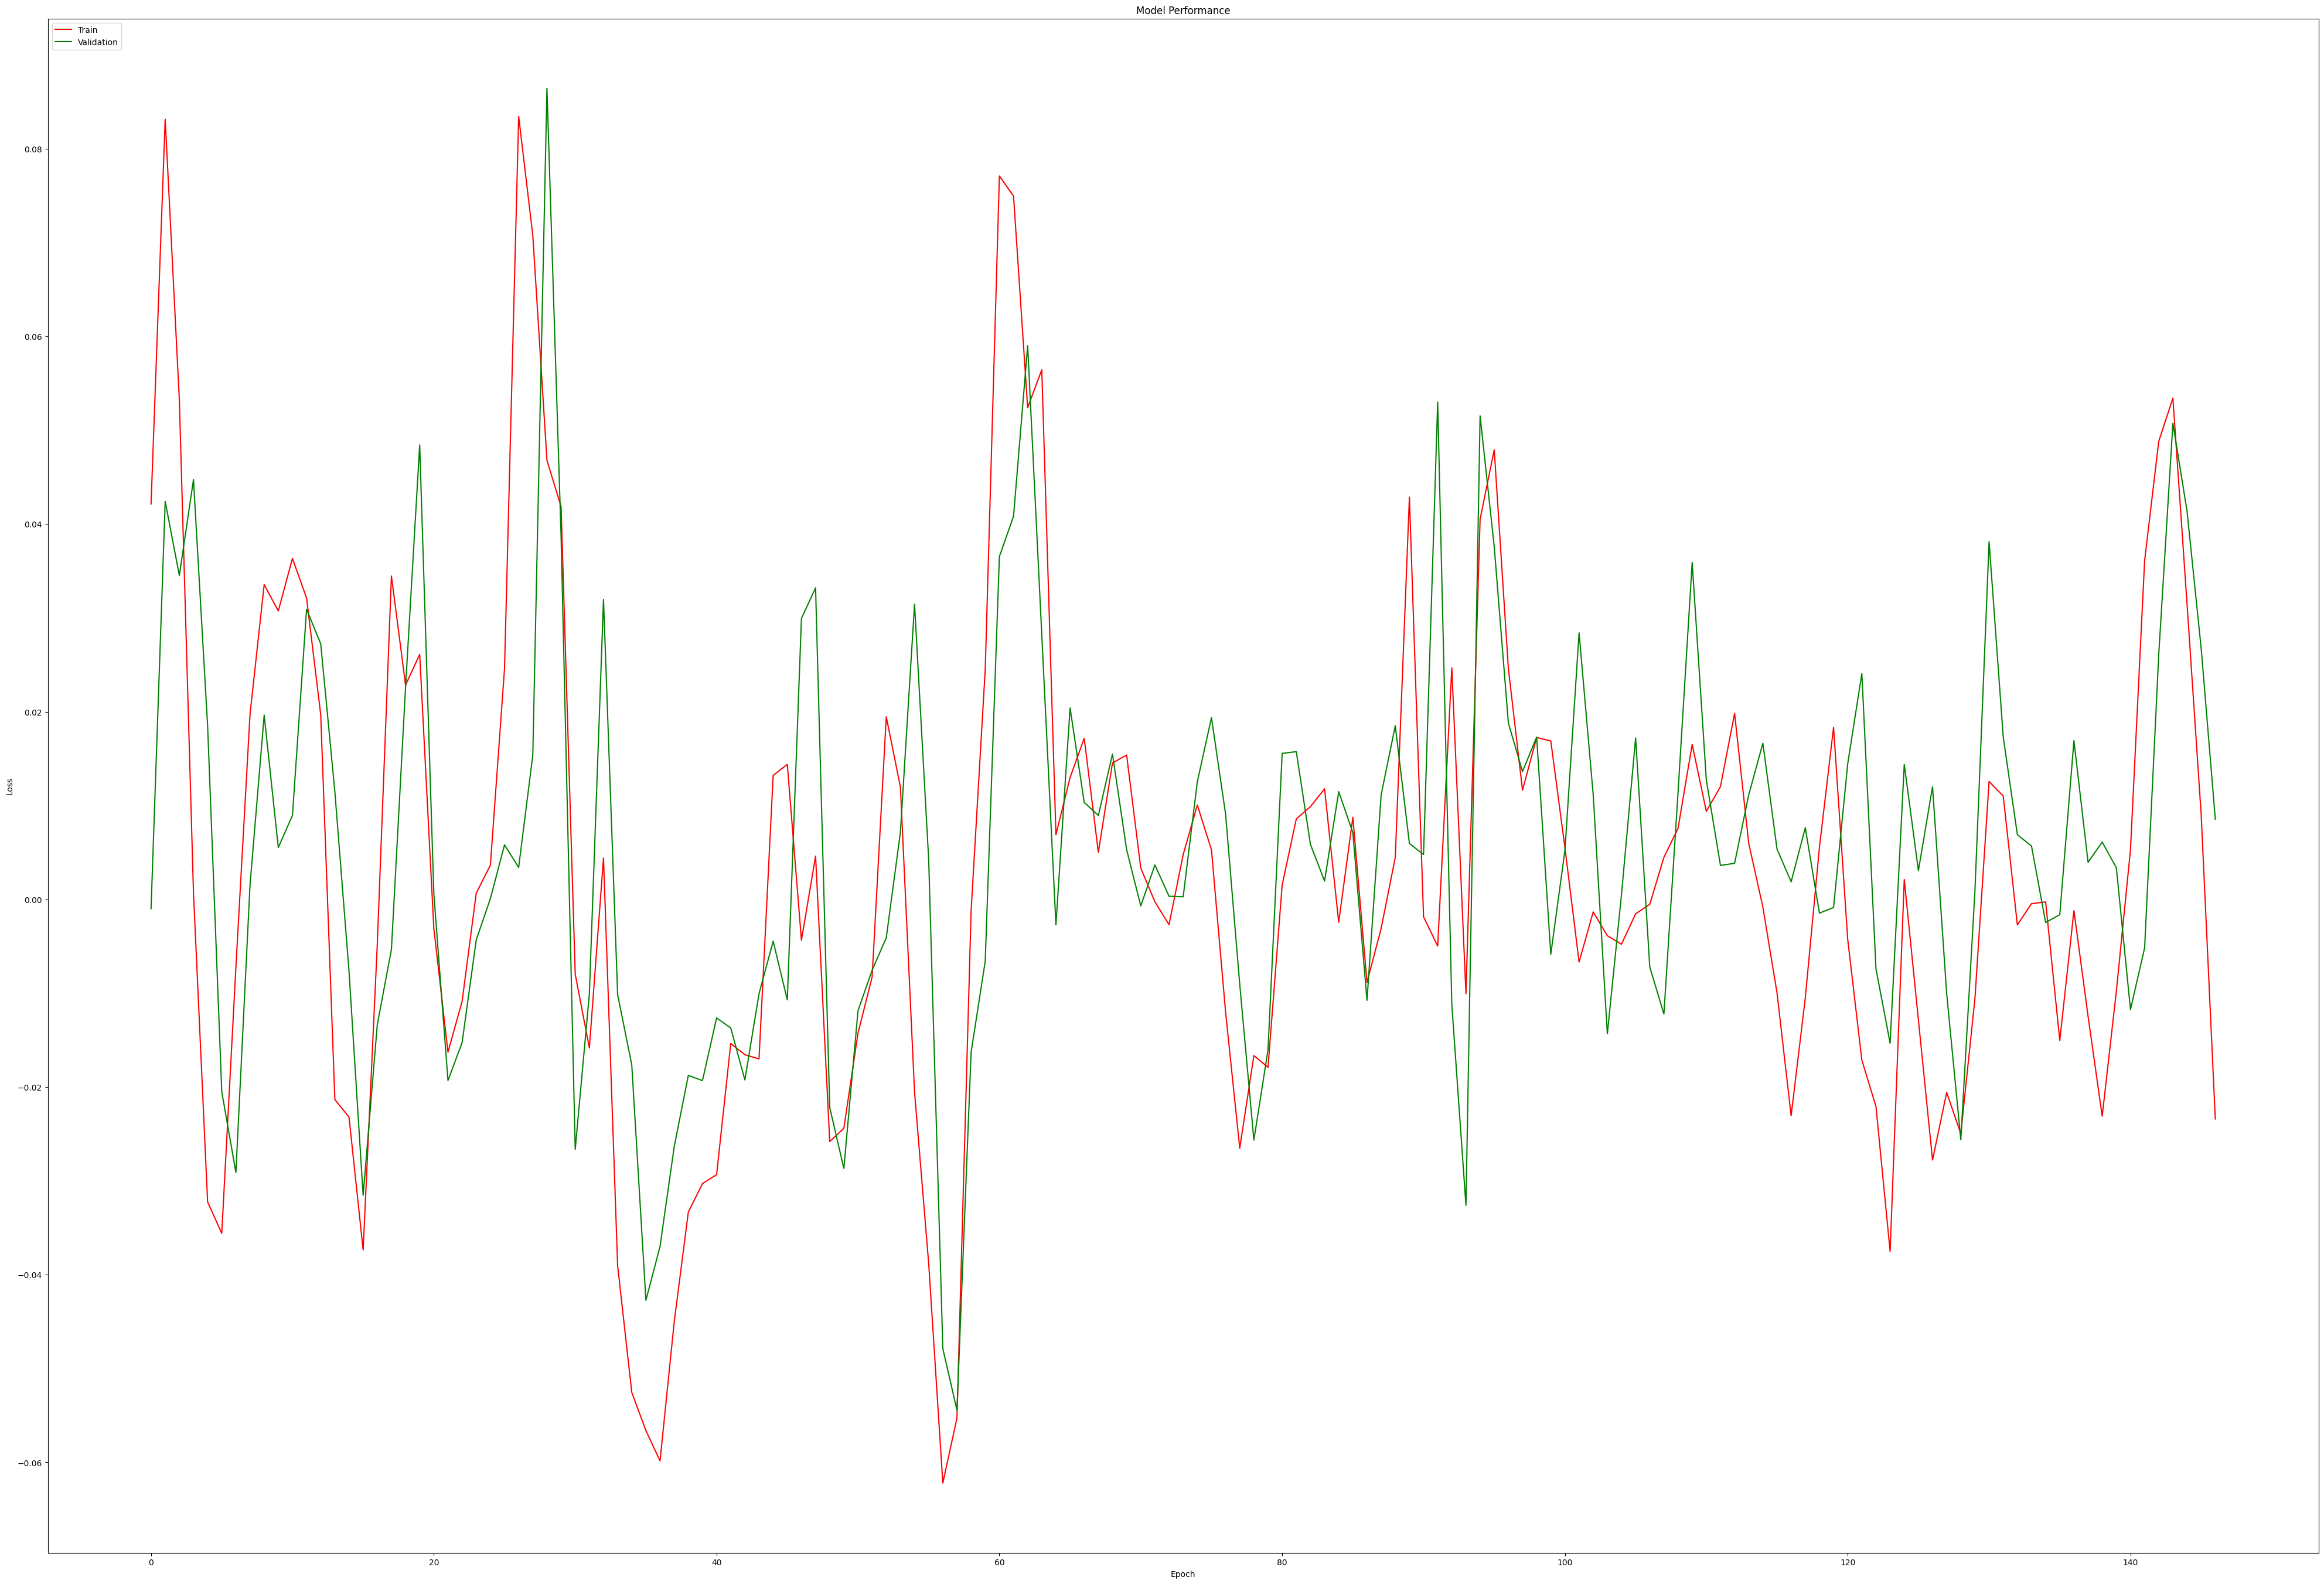

In [434]:
plt.figure(figsize=(50,35))
plt.plot(outs_0['y'], color='red')
plt.plot(outs_0['y_pred'], color='green')
plt.title('Model Performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

'\nplt.plot(outs_0[\'y\'], color=\'red\')\nplt.plot(outs_0[\'y_pred\'], color=\'green\')\nplt.title(\'Model Performance\')\nplt.ylabel(\'Loss\')\nplt.xlabel(\'Epoch\')\nplt.legend([\'Train\', \'Validation\'], loc=\'upper left\')\nplt.show()\nplt.subplot(1, 2, 1)\nplt.plot(x,y)\nplt.title("SALES")\n'

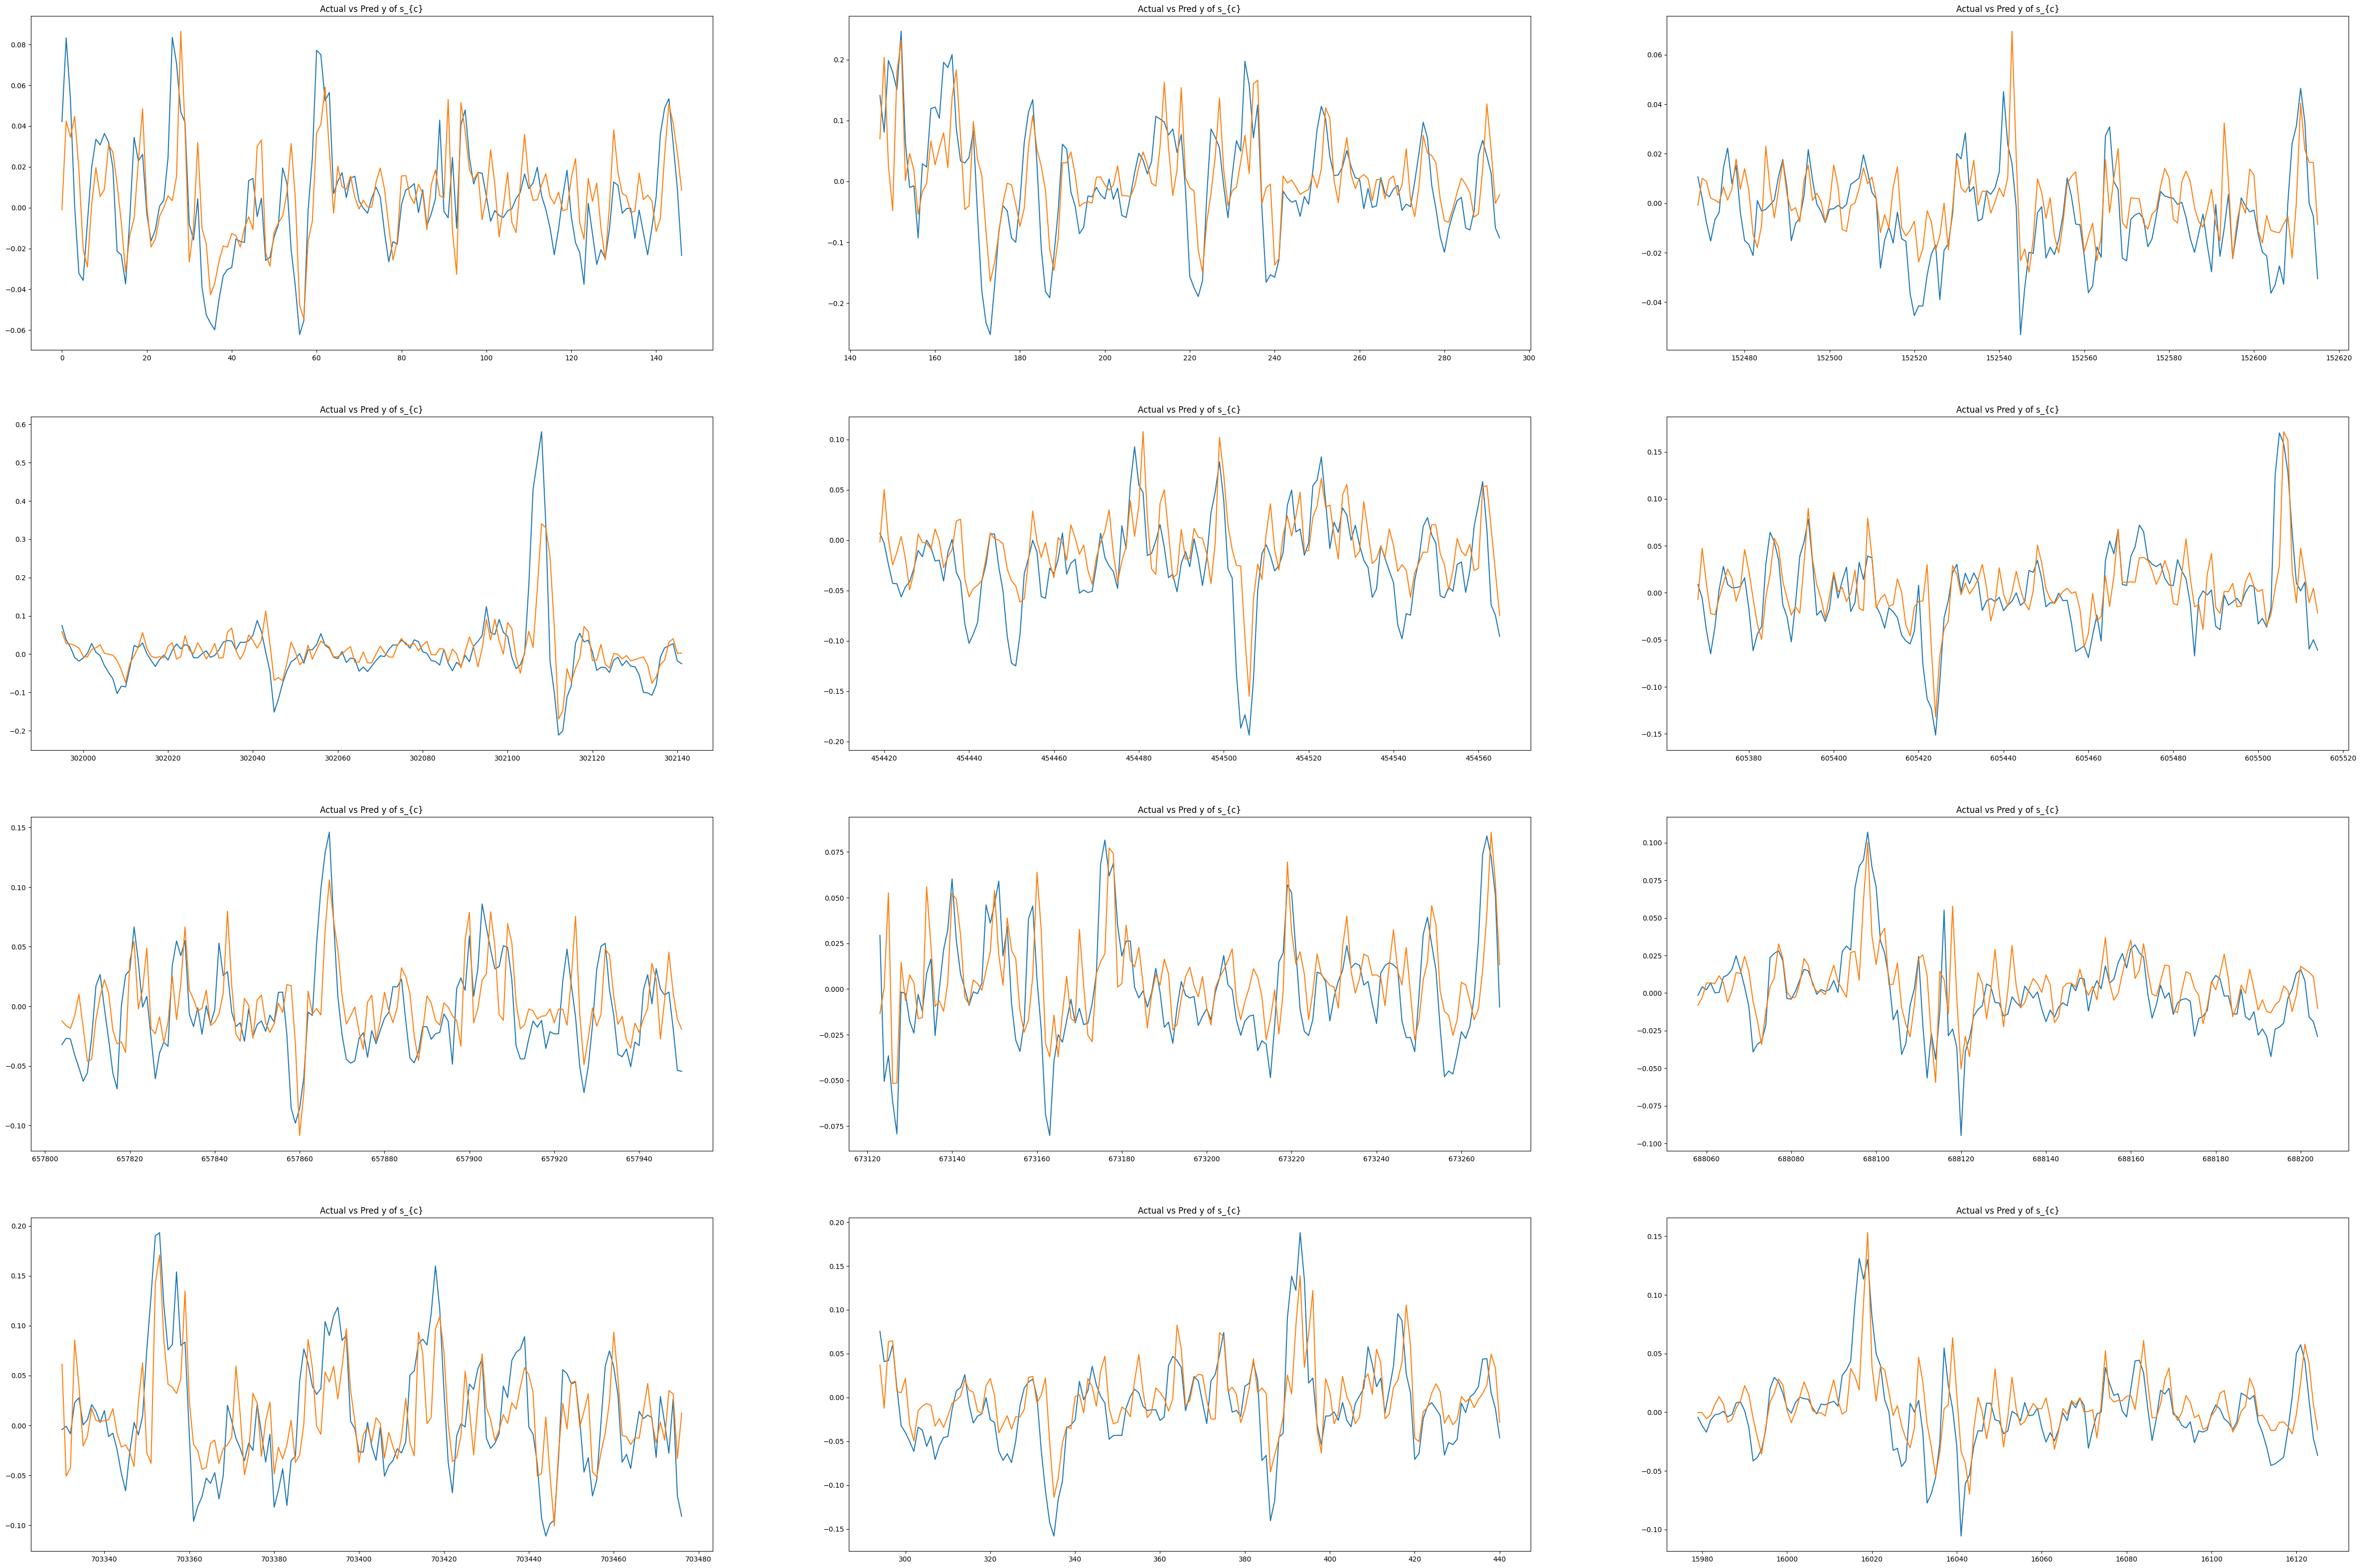

In [452]:
#df.loc[df['Age'] > 30, ['Name', 'City']]
plt.figure(figsize=(60,40))
for c in range(12):
    plt.subplot(4,3,c+1)
    plt.plot(out_df.loc[out_df['code'] == 's_'+str(c), ['y', 'y_pred']])
    plt.title('Actual vs Pred y of s_{c}')
"""
plt.plot(outs_0['y'], color='red')
plt.plot(outs_0['y_pred'], color='green')
plt.title('Model Performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.subplot(1, 2, 1)
plt.plot(x,y)
plt.title("SALES")
"""

In [422]:

"""
out["date"] = pd.to_datetime(out["date"]).dt.strftime("%Y-%m-%d")
out["y_pred"] = pred_test

os.makedirs("outputs", exist_ok=True)
out_path = "outputs/predictions_test_lstm.csv"
out.to_csv(out_path, index=False)
print("Saved:", out_path)
out.head()
"""

'\nout["date"] = pd.to_datetime(out["date"]).dt.strftime("%Y-%m-%d")\nout["y_pred"] = pred_test\n\nos.makedirs("outputs", exist_ok=True)\nout_path = "outputs/predictions_test_lstm.csv"\nout.to_csv(out_path, index=False)\nprint("Saved:", out_path)\nout.head()\n'